In [ ]:
import pandas as pd
import numpy as np
#matplotlib 3.4 version is needed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
plt.style.use("ggplot")

In [ ]:
df = pd.read_csv('listings.txt')

Convert price from string to float.

In [ ]:
df["price"]=df["price"].str.replace("$","").str.replace(",","").astype(float)
df["price"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


0       79.0
1       50.0
2       38.0
3       48.0
4       47.0
        ... 
9577    10.0
9578    31.0
9579    65.0
9580    79.0
9581    53.0
Name: price, Length: 9582, dtype: float64

## Removing redundant columns

In [ ]:
pd.set_option('display.max_columns', None)
df = df.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
                    'neighborhood_overview', 'picture_url', 'host_id',
                     'host_url', 'host_name', 'host_location',
                     'host_about', 'host_thumbnail_url', 'host_picture_url',
                     'host_neighbourhood', 'host_verifications', 'neighbourhood',
                     'neighbourhood_group_cleansed', 'property_type', 'calculated_host_listings_count',
                      'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                      'calculated_host_listings_count_shared_rooms', 'minimum_minimum_nights',
                      'maximum_minimum_nights','minimum_maximum_nights',
                      'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
                    'calendar_updated', 'calendar_last_scraped', 'reviews_per_month',
                     'first_review', 'last_review', 'license', 'host_total_listings_count',
                      'host_listings_count', 'number_of_reviews_ltm', 'number_of_reviews_l30d','host_since'], axis=1)
df.columns

Index(['description', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'instant_bookable'],
      dtype='object')

# Replacing NAs values in the dataset.


Replace Nas for the bathrooms.

In [ ]:
#bathrooms
df["bathrooms"] = df["bathrooms_text"].str.replace("baths","").str.replace("bath","").str.replace("shared","").str.replace("private","").str.replace("Half-","0.5").str.replace("Shared half-","0.5").astype(float)
df.drop("bathrooms_text",axis=1,inplace=True)
df["bathrooms"].isna().sum() #10 NA values
bath_na_dec = pd.DataFrame(df[df["bathrooms"].isna()]["description"])
b = bath_na_dec[bath_na_dec["description"].str.contains("bathrooms|bath|baths|bathroom|μπάνιο|μπάνια|WC|μπανιο|μπανια|ΜΠΑΝΙΑ|ΜΠΑΝΙΟ|τουαλετα|τουαλετες|Bath")]
b

,description
2197,Your “tropical” oasis within the multicultural...
2239,This exceptional Penthouse close to the Acropo...
2487,"Located in a 1930’s neoclassical building, dir..."
3522,Our Family Apartments are situated on the firs...
3969,"This apartment features a balcony, air conditi..."
9264,"Stay in an upscale, stylish suite in the heart..."
9268,"Denoting the epitome of minimal luxury, the Ag..."


In [ ]:
#we will find from the description (b variable) the number of bathrooms
df.loc[[2197,2239],"bathrooms"] = 2.0
df.loc[2487,"bathrooms"] = 3.0
df.loc[[3522,9264,9268,3969],"bathrooms"] = 1.0
#3 more NAs without info in the description, we will replace them with the median
df[df["bathrooms"].isna()] #NA baths in 5017, 5788, 9265
df["bathrooms"] = df["bathrooms"].replace(np.nan,1.0)
# Changing 0 bathrooms with the median.
df["bathrooms"] = df["bathrooms"].replace(0.0,1.0)
df["bathrooms"].describe()

count    9582.000000
mean        1.207264
std         0.513453
min         0.500000
25%         1.000000
50%         1.000000
75%         1.000000
max        12.000000
Name: bathrooms, dtype: float64

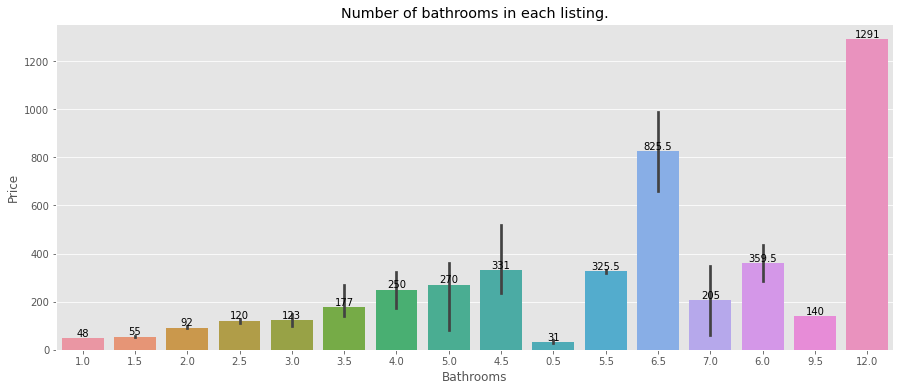

In [ ]:
# Plotting
plt.figure(figsize = (15,6))
ax = sns.barplot(x = 'bathrooms',y="price", order = df['bathrooms'].value_counts().index, data = df,estimator = np.median)
for container in ax.containers:
     ax.bar_label(container)
ax.set_title("Number of bathrooms in each listing.")
plt.xlabel("Bathrooms")
plt.ylabel("Price")
plt.show()

Replace NAs host_response_time with the mode.

In [ ]:
df['host_response_time'].fillna(df['host_response_time'].mode()[0], inplace=True)

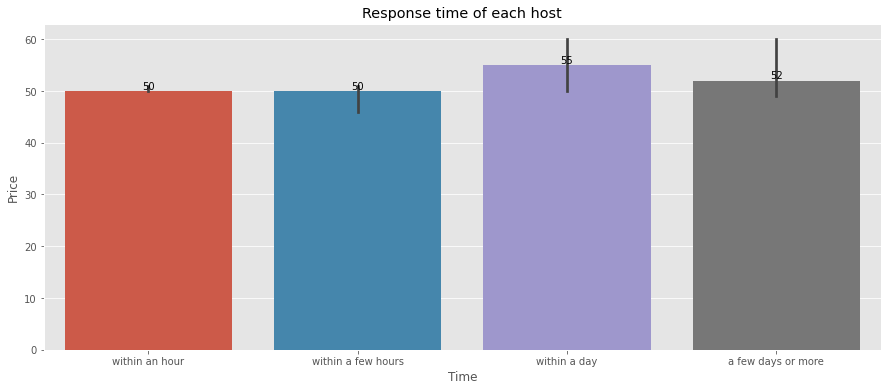

In [ ]:
# Plotting
plt.figure(figsize = (15,6))
ax = sns.barplot(x = 'host_response_time',y="price",
                   order = df['host_response_time'].value_counts().index,
                   data = df,estimator=np.median)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("Response time of each host")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

Replace Nas in host_acceptance_rate, host_is_superhost, host_has_profile_pic with the modes.

In [ ]:
df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].mode()[0], inplace=True)
df['host_is_superhost'].fillna(df['host_is_superhost'].mode()[0], inplace=True)
df['host_has_profile_pic'].fillna(df['host_has_profile_pic'].mode()[0], inplace=True)

info for the host_response_rate variable.

In [ ]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 2244
Proportion: 23.4%


In [ ]:
# Removing the % sign from the 'host_response_rate' string and converting to an integer.
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')
print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 94.0
Median host response rate: 100.0
Proportion of 100% host response rates: 75.9%


## host_acceptance_rate to type float

In [ ]:
def remove_percent(text):
    return text.replace('%','')
df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(remove_percent).astype(float)

## Binning of host_response_rate column

In [ ]:
# Bin into four categories.
df.host_response_rate_bin = pd.cut(df.host_response_rate, bins = [0, 50, 90, 99, 100],
                               labels = ['0-49%', '50-89%', '90-99%', '100%'],
                               include_lowest = True)
# Converting to string.
df.host_response_rate_bin = df.host_response_rate_bin.astype('str')
# Replace nulls with 'unknown'.
df.host_response_rate_bin.replace('nan', 'unknown', inplace=True)
# Category counts.
df.host_response_rate_bin.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


100%       5566
unknown    2244
90-99%      816
50-89%      576
0-49%       380
Name: host_response_rate, dtype: int64

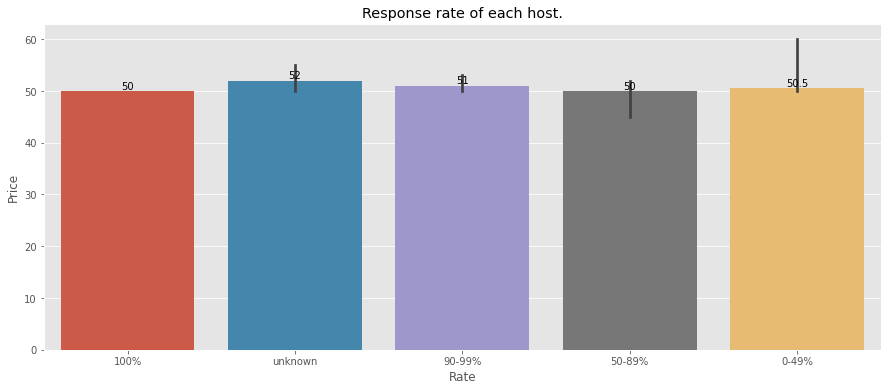

In [ ]:
# Plotting 
plt.figure(figsize = (15,6))
ax = sns.barplot(x = df.host_response_rate_bin, y =df.price,
  order = df.host_response_rate_bin.value_counts().index,
  data = df,estimator = np.median)
for container in ax.containers:
     ax.bar_label(container)
ax.set_title("Response rate of each host.")
plt.xlabel("Rate")
plt.ylabel("Price")
plt.show()

Now that we are done with the binning, we are going to fill NaNs with the mode.

In [ ]:
df['host_response_rate'].fillna(df['host_response_rate'].mode()[0], inplace=True)

## host_identity_verified

Fill NAs with the mode of host_identity verified.

In [ ]:
df['host_identity_verified'].fillna(df['host_identity_verified'].mode()[0], inplace=True)

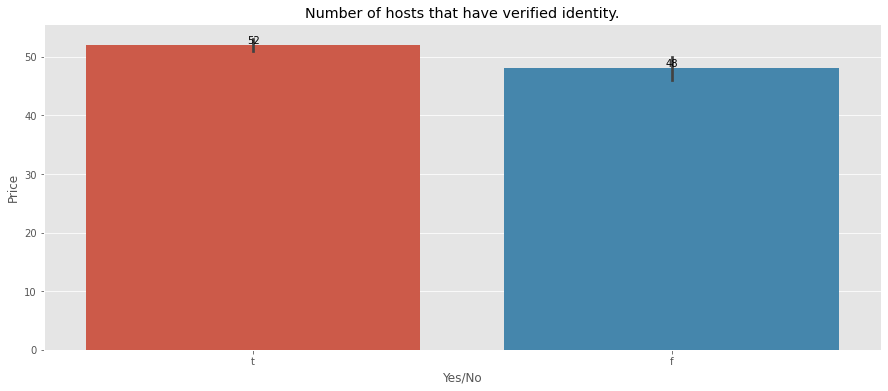

In [ ]:
# Plotting
plt.figure(figsize = (15,6))
ax = sns.barplot(x = 'host_identity_verified',y="price",
                   order = df['host_identity_verified'].value_counts().index,
                   data = df,estimator=np.median)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("Number of hosts that have verified identity.")
plt.xlabel("Yes/No")
plt.ylabel("Price")
plt.show()

## beds

In [ ]:
df['beds'].fillna(df['beds'].mode()[0], inplace=True)

## Bedrooms

In [ ]:
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())

## Plot and removal of `availability` columns

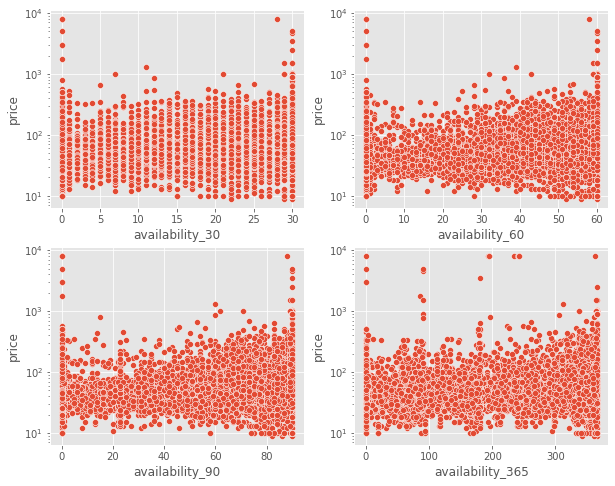

In [ ]:
# Plot for price and availability_30,60,90,365
f, ((ax1,ax2),(ax3,ax4))= plt.subplots(2,2,figsize=(10,8))
x=[30,60,90,365]
i=0
ax1 = plt.subplot(2,2,1)
ax1 = sns.scatterplot(y="price",x="availability_{}".format(x[0]),data=df)
plt.yscale("log")
ax2 = plt.subplot(2,2,2)
ax2 = sns.scatterplot(y="price",x="availability_{}".format(x[i+1]),data=df,
ax=ax2)
plt.yscale("log")
ax3 =plt.subplot(2,2,3)
ax3 = sns.scatterplot(y="price",x="availability_{}".format(x[i+2]),data=df,
ax=ax3)
plt.yscale("log")
ax4=plt.subplot(2,2,4)
ax4 = sns.scatterplot(y="price",x="availability_{}".format(x[i+3]),data=df,
ax=ax4)
plt.yscale("log")
plt.show()
# Drop availability_30,_60,_90_365
av = ["availability_30","availability_60","availability_90","availability_365"]
df.drop(av,axis=1,inplace=True)

## Drop `description` columns

In [ ]:
df.drop(columns=['description'], axis=1, inplace=True)

## Drop `neighbourhood_cleansed` column sicne we have `latitude` and `longitude`

In [ ]:
df.drop('neighbourhood_cleansed', axis=1, inplace=True)

In [ ]:
df.isna().sum()

host_response_time        0
host_response_rate        0
host_acceptance_rate      0
host_is_superhost         0
host_has_profile_pic      0
host_identity_verified    0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
amenities                 0
price                     0
minimum_nights            0
maximum_nights            0
has_availability          0
number_of_reviews         0
instant_bookable          0
dtype: int64

#Up until now we have removed the NAs values from the dataset

## Convert the below columns to boolean 1-0

In [ ]:
df["host_is_superhost"] = df["host_is_superhost"].map({"f":0,"t":1})
df["host_has_profile_pic"] = df["host_has_profile_pic"].map({"f":0,"t":1})
df["host_identity_verified"] = df["host_identity_verified"].map({"f":0,"t":1})
df["has_availability"] = df["has_availability"].map({"f":0,"t":1})
df["instant_bookable"] = df["instant_bookable"].map({"f":0,"t":1})

###Encode Room type and host_response_time with dummies

In [ ]:
df = pd.concat([df, pd.get_dummies(df.room_type)], axis=1)
df.drop("room_type",axis=1,inplace=True)
df = pd.concat([df, pd.get_dummies(df.host_response_time)], axis=1)
df.drop("host_response_time",axis=1,inplace=True)

###Amenities

In [ ]:
x = ["Essentials","Wifi","Air conditioning","Hangers","Iron","Hair dryer", 
     "Kitchen","Heating","Hot water","Dishes and silverware","TV", 
     "Cooking basics","Refrigerator","Coffee maker","Dedicated workspace",
     "Shampoo","Bed linens","Elevator","Fire extinguisher","First aid kit",
     "Smoke alarm","Lockbox","Backyard","Nespresso machine","Breakfast",
     "Security cameras on property"]
lyes = []
lno = []
for i in range(26):
    lyes.append(df[df["amenities"].str.contains( "{}".format(x[i]))]["price"].median())
    lno.append(df[~df["amenities"].str.contains("{}".format(x[i]))]["price"].median())
diff_medians = [lyes_i - lno_i for lyes_i, lno_i in zip(lyes, lno)]

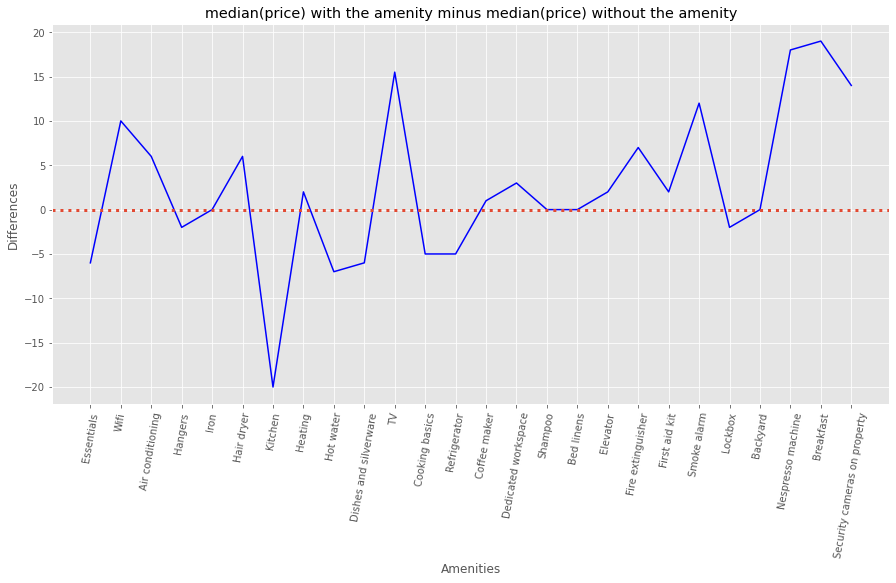

In [ ]:
# Plotting
f, ax = plt.subplots(1,1,figsize=(15,7))
plt.plot(diff_medians,c="b")
plt.xticks([0,5,10,15,20,25])
plt.axhline(y=0, linewidth=3, label= 'horizontal-line',linestyle="dotted")
plt.title("median(price) with the amenity minus median(price) without the amenity")
plt.ylabel("Differences")
plt.xlabel("Amenities")
plt.xticks(range(26),x,rotation=80)
plt.show()

In [ ]:
# According to the plot we will choose the amenities with the most impact in price.
diff_medians =pd.DataFrame(diff_medians)
diff_medians["amenities"] = x
diff_medians.rename(columns = {0:"diff_yes_m_no"},inplace=True)
diff_medians["diff_yes_m_no"].abs().sort_values(ascending=False)
# We will keep 6,24,23,10,20,1,18,8
useful_amenities= [x[6],x[24],x[23],x[10],x[25],x[20],x[1],x[18],x[8]]
useful_amenities

['Kitchen',
 'Breakfast',
 'Nespresso machine',
 'TV',
 'Security cameras on property',
 'Smoke alarm',
 'Wifi',
 'Fire extinguisher',
 'Hot water']

In [ ]:
# We will insert these amenities in df as new columns
# Kitchen
boolean = df["amenities"].str.contains('Kitchen')
q = []
for i in range(df.shape[0]):
    if boolean[i]:
        q.append(1)
    else:
             q.append(0)
df["kitchen"] = q
# Breakfast
boolean = df["amenities"].str.contains('Breakfast')
q = []
for i in range(df.shape[0]):
    if boolean[i]:
        q.append(1)
    else:
        q.append(0)
df["Breakfast"] = q
# Nespresso machine
boolean = df["amenities"].str.contains('Nespresso machine')
q = []
for i in range(df.shape[0]):
    if boolean[i]:
        q.append(1)
    else:
        q.append(0)
df["Nespresso machine"] = q
#TV
boolean = df["amenities"].str.contains('TV')
q = []
for i in range(df.shape[0]):
    if boolean[i]:
        q.append(1)
    else:
        q.append(0)
df["TV"] = q
# Security cameras on property
boolean = df["amenities"].str.contains('Security cameras on property')
q = []
for i in range(df.shape[0]):
    if boolean[i]:
        q.append(1)
    else:
        q.append(0)
df["security_cameras"] = q
# Smoke alarm
boolean = df["amenities"].str.contains('Smoke alarm')
q = []
for i in range(df.shape[0]):
    if boolean[i]:
        q.append(1)
    else:
        q.append(0)
df["Smoke alarm"] = q
#Wifi
boolean = df["amenities"].str.contains('Wifi')
q = []
for i in range(df.shape[0]):
    if boolean[i]:
        q.append(1)
    else:
        q.append(0)
df["Wifi"] = q
# Fire extinguisher
boolean = df["amenities"].str.contains('Fire extinguisher')
q = []
for i in range(df.shape[0]):
    if boolean[i]:
        q.append(1)
    else:
        q.append(0)
df["Fire_extinguisher"] = q
# Hot water
boolean = df["amenities"].str.contains('Hot water')
q = []
for i in range(df.shape[0]):
    if boolean[i]:
        q.append(1)
    else:
        q.append(0)
df["hot_water"] = q

In [ ]:
df.drop("amenities",axis=1,inplace=True)
#all the features are numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_rate      9582 non-null   float64
 1   host_acceptance_rate    9582 non-null   float64
 2   host_is_superhost       9582 non-null   int64  
 3   host_has_profile_pic    9582 non-null   int64  
 4   host_identity_verified  9582 non-null   int64  
 5   latitude                9582 non-null   float64
 6   longitude               9582 non-null   float64
 7   accommodates            9582 non-null   int64  
 8   bathrooms               9582 non-null   float64
 9   bedrooms                9582 non-null   float64
 10  beds                    9582 non-null   float64
 11  price                   9582 non-null   float64
 12  minimum_nights          9582 non-null   int64  
 13  maximum_nights          9582 non-null   int64  
 14  has_availability        9582 non-null   

#Outliers

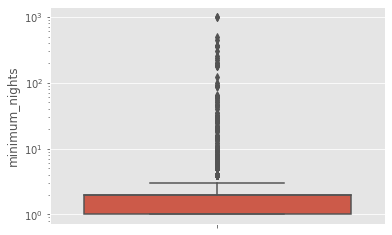

In [ ]:
f, ax = plt.subplots(1,1)
ax = sns.boxplot(data=df,y="minimum_nights")
plt.yscale("log")
plt.show()

Transform minimum_nights using log.

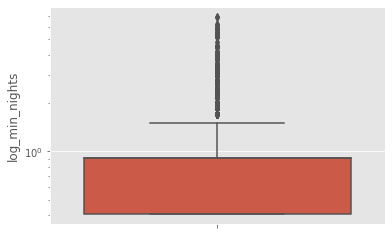

In [ ]:
df.loc[:,"log_min_nights"] = np.log(df["minimum_nights"]+0.5)
ax = sns.boxplot(data=df,y="log_min_nights")
plt.yscale("log")
plt.show()

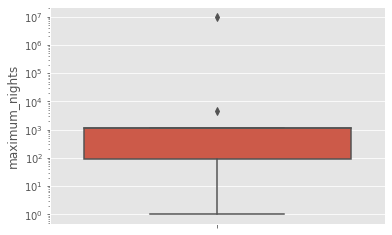

In [ ]:
sns.boxplot(data=df,y="maximum_nights")
plt.yscale("log")
plt.show()

Transform maximum_nights using log.

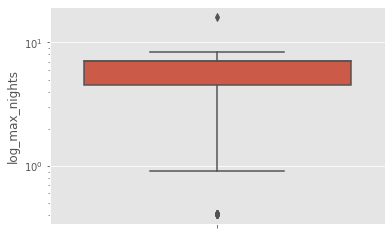

In [ ]:
df.loc[:,"log_max_nights"] = np.log(df["maximum_nights"]+0.5)
sns.boxplot(data=df,y="log_max_nights")
plt.yscale("log")
plt.show()

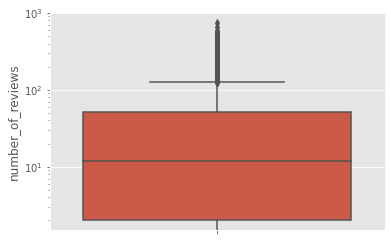

In [ ]:
sns.boxplot(y="number_of_reviews",data=df)
plt.yscale("log")
plt.show()

Transform nunber_of reviews using log.

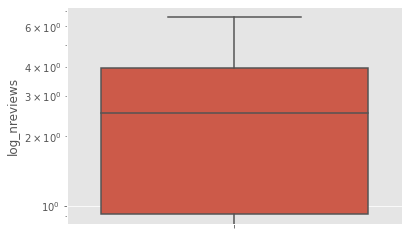

In [ ]:
df.loc[:,"log_nreviews"] = np.log(df["number_of_reviews"]+0.5)
sns.boxplot(y="log_nreviews",data=df)
plt.yscale("log")
plt.show()

<AxesSubplot:ylabel='accommodates'>

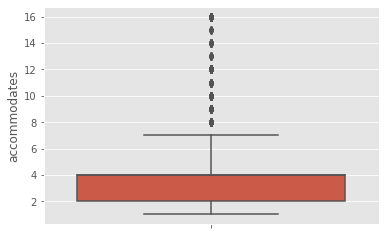

In [ ]:
sns.boxplot(y="accommodates",data=df)

<AxesSubplot:ylabel='log_accommo'>

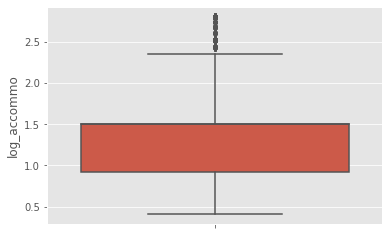

In [ ]:
df.loc[:,"log_accommo"] = np.log(df["accommodates"]+0.5)
sns.boxplot(y="log_accommo",data=df)

In [ ]:
df.drop(["maximum_nights","minimum_nights","accommodates", "number_of_reviews"],inplace=True,axis=1)

### Feature Selection

<AxesSubplot:>

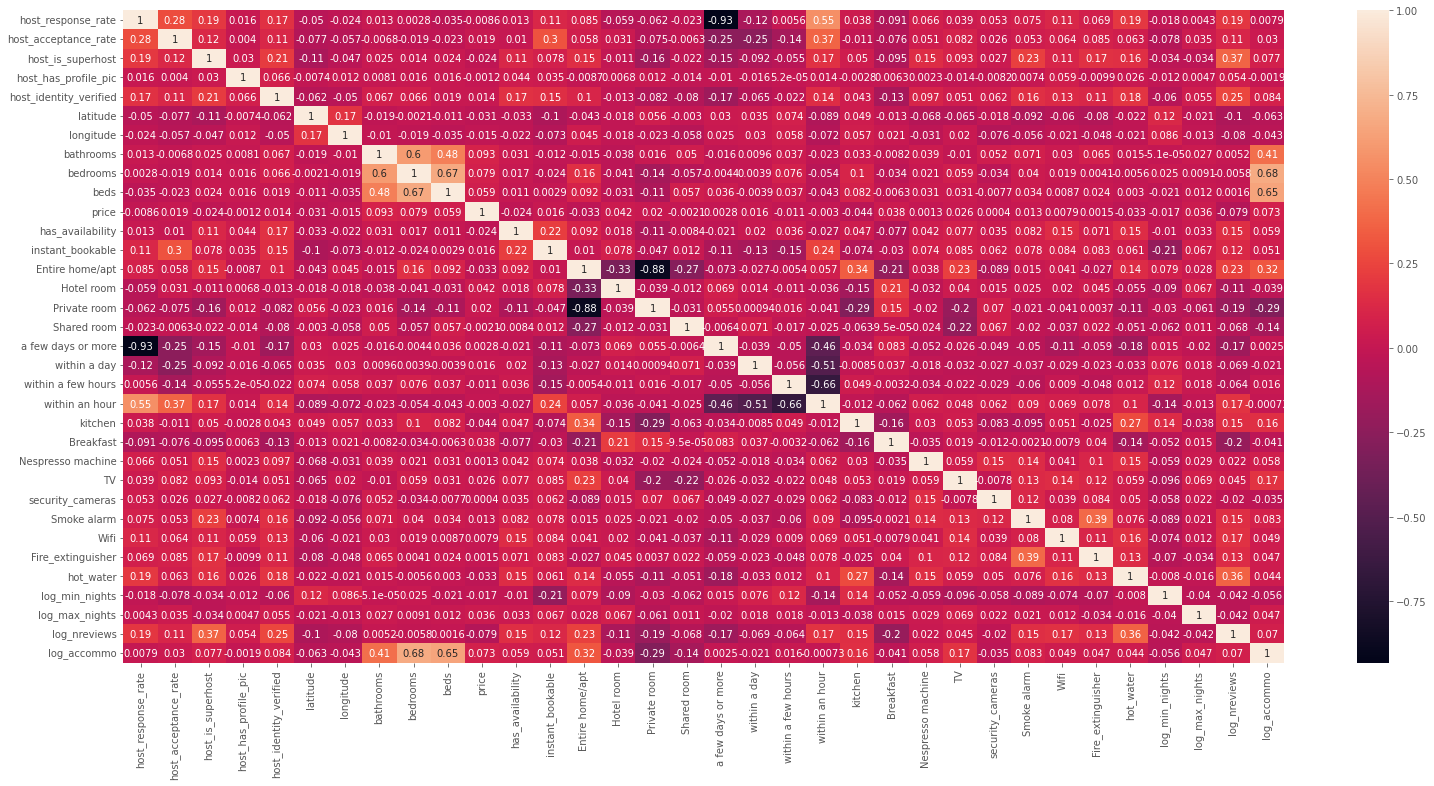

In [ ]:
#heatmap
corr = df.corr()
plt.figure(figsize=(26,12))
sns.heatmap(corr, annot=True)

### Feature Selection - Lasso Regression

In [ ]:
x = df.drop("price",axis=1)
y = df["price"]
#feature selection
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,
                                                    random_state=(10))
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
# creating a pipeline to scale and model
pipeline = Pipeline([('sc',StandardScaler()),('model',Lasso())])
# gridsearch over the pipeline to find the best alpha for lasso
# scoring is picked as mean squared error
lassocv = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.2)},
                      cv = 5, scoring="neg_root_mean_squared_error"
                      )
# fitting to the model
lassocv.fit(x_train,y_train)
# dataframe of variables, coefficients and absolute coefficients 
coefs = pd.DataFrame({'variable':x.columns,
'coef':lassocv.best_estimator_.named_steps['model'].coef_,
'abs_coef':np.abs(lassocv.best_estimator_.named_steps['model'].coef_)})
# sorting based on the absolute of the coefficients
coefs.sort_values('abs_coef', inplace=True, ascending=False)
coefs

,variable,coef,abs_coef
31,log_nreviews,-26.827412,26.827412
7,bathrooms,22.227756,22.227756
32,log_accommo,11.712910,11.712910
5,latitude,-11.509813,11.509813
10,has_availability,-10.044638,10.044638
20,kitchen,-8.734694,8.734694
4,host_identity_verified,7.993933,7.993933
23,TV,6.763718,6.763718
30,log_max_nights,5.588502,5.588502
1,host_acceptance_rate,5.425294,5.425294


<AxesSubplot:>

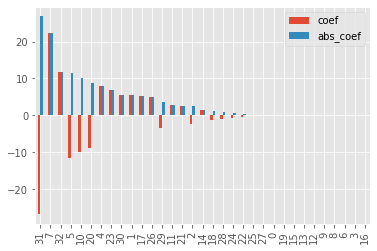

In [ ]:
coefs.plot(kind="bar")

In [ ]:
clean_df = df.drop(["a few days or more","host_has_profile_pic","longitude","bedrooms","beds","Entire home/apt","Hotel room","Shared room",
               "within an hour","host_response_rate","Fire_extinguisher","Smoke alarm"],axis=1)

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_acceptance_rate    9582 non-null   float64
 1   host_is_superhost       9582 non-null   int64  
 2   host_identity_verified  9582 non-null   int64  
 3   latitude                9582 non-null   float64
 4   bathrooms               9582 non-null   float64
 5   price                   9582 non-null   float64
 6   has_availability        9582 non-null   int64  
 7   instant_bookable        9582 non-null   int64  
 8   Private room            9582 non-null   uint8  
 9   within a day            9582 non-null   uint8  
 10  within a few hours      9582 non-null   uint8  
 11  kitchen                 9582 non-null   int64  
 12  Breakfast               9582 non-null   int64  
 13  Nespresso machine       9582 non-null   int64  
 14  TV                      9582 non-null   

### Second algorithm for feature selection: Boruta

In [24]:
data= pd.read_csv('final_clean.csv')
data=data.drop(['Unnamed: 0'],axis=1)
data.info()
X = data.drop('price', axis = 1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9545 entries, 0 to 9544
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_time      9545 non-null   int64  
 1   host_response_rate      9545 non-null   int64  
 2   host_acceptance_rate    9545 non-null   int64  
 3   host_is_superhost       9545 non-null   int64  
 4   host_has_profile_pic    9545 non-null   int64  
 5   host_identity_verified  9545 non-null   int64  
 6   latitude                9545 non-null   float64
 7   longitude               9545 non-null   float64
 8   bathrooms               9545 non-null   float64
 9   bedrooms                9545 non-null   int64  
 10  beds                    9545 non-null   int64  
 11  price                   9545 non-null   int64  
 12  has_availability        9545 non-null   int64  
 13  instant_bookable        9545 non-null   int64  
 14  Entire home/apt         9545 non-null   

In [26]:
import numpy as np
### make X_shadow by randomly permuting each column of X
np.random.seed(42)
X_shadow = X.apply(np.random.permutation)
X_shadow.columns = ['shadow_' + feat for feat in X.columns]
### make X_boruta by appending X_shadow to X
X_boruta = pd.concat([X, X_shadow], axis = 1)
from sklearn.ensemble import RandomForestRegressor
### fit a random forest (suggested max_depth between 3 and 7)
forest = RandomForestRegressor(max_depth = 5, random_state = 42)
forest.fit(X_boruta, y)
### store feature importances
feat_imp_X = forest.feature_importances_[:len(X.columns)]
feat_imp_shadow = forest.feature_importances_[len(X.columns):]
### compute hits
hits = feat_imp_X > feat_imp_shadow.max()
### initialize hits counter
hits = np.zeros((len(X.columns)))
### repeat 20 times
for iter_ in range(20):
   ### make X_shadow by randomly permuting each column of X
   np.random.seed(iter_)
   X_shadow = X.apply(np.random.permutation)
   X_boruta = pd.concat([X, X_shadow], axis = 1)
   ### fit a random forest (suggested max_depth between 3 and 7)
   forest = RandomForestRegressor(max_depth = 5, random_state = 42)
   forest.fit(X_boruta, y)
   ### store feature importance
   feat_imp_X = forest.feature_importances_[:len(X.columns)]
   feat_imp_shadow = forest.feature_importances_[len(X.columns):]
   ### compute hits for this trial and add to counter
   hits += (feat_imp_X > feat_imp_shadow.max())

In [27]:
import scipy as sp
trials = 100
pmf = [sp.stats.binom.pmf(x, trials, .5) for x in range(trials + 1)]

In [30]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np
###initialize Boruta
forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 5
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(y))
### print results
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()
print('features that are accepted:', green_area)


features that are accepted: ['host_response_rate', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'kitchen', 'log_max_nights', 'log_nreviews', 'log_accommo']
